# Import Libraries and Tools to Use

In [155]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import tensorboard
import tensorflow as tf
import itertools

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\schne\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\schne\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\schne\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\schne\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Import the Dataset 

In [164]:
#Read the data
df=pd.read_excel('EBD3.xlsx')

#Get shape and head
df.shape
df.head()

,ApplicationNumber,Random Number,Year,RecipientId,RecipientName,LineItemNumber,Text,SectionCode,Total,FTATotal,LocalTotal,Label,Classification
0,MI-2018-004-00,0.000316,2018,7334,Central County Transportation Authority,11.42.07,Upgrades to existing ADA Hardware in board mee...,90,68750,55000,13750,0,Conventional
1,IA-2020-009-00,0.001544,2020,1832,"DUBUQUE, THE CITY OF (INC)",11.42.07,"Unit cost is $3,041: $2,432.80 Federal, $608.2...",34,399941,319953,79988,1,Innovative
2,SC-2019-001-00,0.001688,2019,5526,"WACCAMAW REGIONAL TRANSPORTATION AUTHORITY, INC.",11.42.07,Waccamaw RTA will acquire two new servers from...,90,18000,14400,3600,0,Conventional
3,AL-2020-001-00,0.002720,2020,1073,Birmingham-Jefferson County Transit Authority,11.42.08,"Purchase VM Ware Upgrade priced at $25,382 ($2...",90,163875,131100,32775,0,Conventional
4,MN-2020-032-00,0.003098,2020,1305,"METROPOLITAN COUNCIL, MINNESOTA",11.42.10,This project will use FY 2019 5307 funds in th...,90,1675000,1340000,335000,1,Innovative


# Do Some Prelimnary Analysis and Quality Checks 

In [165]:
df.shape

(200, 13)

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ApplicationNumber  200 non-null    object 
 1   Random Number      200 non-null    float64
 2   Year               200 non-null    int64  
 3   RecipientId        200 non-null    int64  
 4   RecipientName      200 non-null    object 
 5   LineItemNumber     200 non-null    object 
 6   Text               200 non-null    object 
 7   SectionCode        200 non-null    int64  
 8   Total              200 non-null    int64  
 9   FTATotal           200 non-null    int64  
 10  LocalTotal         200 non-null    int64  
 11  Label              200 non-null    int64  
 12  Classification     200 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 20.4+ KB


In [167]:
df.isnull().sum()

ApplicationNumber    0
Random Number        0
Year                 0
RecipientId          0
RecipientName        0
LineItemNumber       0
Text                 0
SectionCode          0
Total                0
FTATotal             0
LocalTotal           0
Label                0
Classification       0
dtype: int64

In [168]:
#check for duplicate rows--it looks like there may be one...
print(df.duplicated().sum())

0


In [169]:
#let's see if we can find it....
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
195    False
196    False
197    False
198    False
199    False
Length: 200, dtype: bool

# Perform Some Exploratory Data Analysis 

In [170]:
#obtain some descriptive statistics....
df.describe()

,Random Number,Year,RecipientId,SectionCode,Total,FTATotal,LocalTotal,Label
count,200.000000,200.000000,200.000000,200.000000,2.000000e+02,2.000000e+02,2.000000e+02,200.000000
mean,0.080797,2019.135000,2114.630000,67.625000,5.766286e+05,4.687367e+05,1.078919e+05,0.405000
std,0.047516,0.836825,1764.147116,30.967553,4.427639e+06,3.546070e+06,8.905614e+05,0.492124
min,0.000316,2018.000000,1000.000000,16.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,0.042929,2018.000000,1109.500000,34.000000,2.500000e+04,2.000000e+04,0.000000e+00,0.000000
50%,0.078344,2019.000000,1401.000000,90.000000,7.500000e+04,6.000000e+04,4.978500e+03,0.000000
75%,0.116887,2020.000000,1818.750000,90.000000,2.015528e+05,1.650000e+05,2.692125e+04,1.000000
max,0.168873,2021.000000,7334.000000,95.000000,6.209300e+07,4.967440e+07,1.241860e+07,1.000000


In [171]:
# identify the numebr of 0 (conventional) and 1 (innoovative ) technologies
count_label=df['Label'].value_counts()
count_label

0    119
1     81
Name: Label, dtype: int64

In [172]:
#express the technology breakdown as a proportion
(count_label[:2]/df.shape[0])

0    0.595
1    0.405
Name: Label, dtype: float64

In [173]:
#mean FTA award amount by technology type 
df.groupby(by='Label')['FTATotal'].mean()

Label
0    586797.638655
1    295289.197531
Name: FTATotal, dtype: float64

In [174]:
#median award amount by technology type 
df.groupby(by='Label')['FTATotal'].median()

Label
0    60305
1    57568
Name: FTATotal, dtype: int64

In [175]:
#standard deviation of the award amount by technology type 
df.groupby(by='Label')['FTATotal'].std()

Label
0    4.568232e+06
1    6.683960e+05
Name: FTATotal, dtype: float64

C:\Users\schne\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


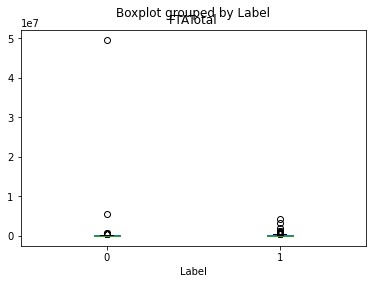

In [176]:
#boxplots of award aount by technology 
df.boxplot(by ='Label', column =['FTATotal'], grid = False) 

In [178]:
#identify the mean FTA funding, local funding, and total funding by category 
pivot = pd.pivot_table(df, index='Label',  aggfunc='mean',fill_value=0)
pivot.sort_values(by='Label')

,FTATotal,LocalTotal,Random Number,RecipientId,SectionCode,Total,Year
Label,,,,,,,
0,586797.638655,138243.941176,0.085466,2145.848739,70.630252,725041.579832,2019.000000
1,295289.197531,63300.679012,0.073938,2068.765432,63.209877,358589.876543,2019.333333


In [179]:
# identify the FTA funding programs funding all technologies 
count_code=df['SectionCode'].value_counts()
count_code

90    122
34     29
16     20
18     15
54      6
95      5
79      1
65      1
26      1
Name: SectionCode, dtype: int64

In [180]:
#show the proportion of funding programs funding all technologies 
(count_code/df.shape[0])

90    0.610
34    0.145
16    0.100
18    0.075
54    0.030
95    0.025
79    0.005
65    0.005
26    0.005
Name: SectionCode, dtype: float64

In [181]:
#create a subset of only conventional technologies 
df1=df[(df.Classification=='Conventional')]
df1.head()


,ApplicationNumber,Random Number,Year,RecipientId,RecipientName,LineItemNumber,Text,SectionCode,Total,FTATotal,LocalTotal,Label,Classification
0,MI-2018-004-00,0.000316,2018,7334,Central County Transportation Authority,11.42.07,Upgrades to existing ADA Hardware in board mee...,90,68750,55000,13750,0,Conventional
2,SC-2019-001-00,0.001688,2019,5526,"WACCAMAW REGIONAL TRANSPORTATION AUTHORITY, INC.",11.42.07,Waccamaw RTA will acquire two new servers from...,90,18000,14400,3600,0,Conventional
3,AL-2020-001-00,0.002720,2020,1073,Birmingham-Jefferson County Transit Authority,11.42.08,"Purchase VM Ware Upgrade priced at $25,382 ($2...",90,163875,131100,32775,0,Conventional
5,PA-2020-010-00,0.003694,2020,5195,MID MON-VALLEY TRANSIT AUTHORITY,11.42.10,This Activity Line Item (ALI) will use Section...,90,75381,60305,15076,0,Conventional
7,NM-2018-002-00,0.007022,2018,1564,"TRANSPORTATION, NEW MEXICO DEPARTMENT OF",11.42.07,"ARCA to purchase 9 Smart Travel devices - $25,...",16,31723,25378,6345,0,Conventional


In [182]:
# count the number of funding programs for conventional technologies  
count_code0=df1['SectionCode'].value_counts()
count_code0

90    79
34    13
18    12
16     7
54     5
95     2
65     1
Name: SectionCode, dtype: int64

In [183]:
#identify the proportion of funding programs for conventional technologies 
(count_code0/df1.shape[0])

90    0.663866
34    0.109244
18    0.100840
16    0.058824
54    0.042017
95    0.016807
65    0.008403
Name: SectionCode, dtype: float64

In [184]:
#create a subset of only conventional technologies 
df2=df[(df.Classification=='Innovative')]
df1.head()


,ApplicationNumber,Random Number,Year,RecipientId,RecipientName,LineItemNumber,Text,SectionCode,Total,FTATotal,LocalTotal,Label,Classification
0,MI-2018-004-00,0.000316,2018,7334,Central County Transportation Authority,11.42.07,Upgrades to existing ADA Hardware in board mee...,90,68750,55000,13750,0,Conventional
2,SC-2019-001-00,0.001688,2019,5526,"WACCAMAW REGIONAL TRANSPORTATION AUTHORITY, INC.",11.42.07,Waccamaw RTA will acquire two new servers from...,90,18000,14400,3600,0,Conventional
3,AL-2020-001-00,0.002720,2020,1073,Birmingham-Jefferson County Transit Authority,11.42.08,"Purchase VM Ware Upgrade priced at $25,382 ($2...",90,163875,131100,32775,0,Conventional
5,PA-2020-010-00,0.003694,2020,5195,MID MON-VALLEY TRANSIT AUTHORITY,11.42.10,This Activity Line Item (ALI) will use Section...,90,75381,60305,15076,0,Conventional
7,NM-2018-002-00,0.007022,2018,1564,"TRANSPORTATION, NEW MEXICO DEPARTMENT OF",11.42.07,"ARCA to purchase 9 Smart Travel devices - $25,...",16,31723,25378,6345,0,Conventional


In [185]:
# count the number of funding programs for conventional technologies  
count_code1=df2['SectionCode'].value_counts()
count_code1

90    43
34    16
16    13
95     3
18     3
79     1
54     1
26     1
Name: SectionCode, dtype: int64

In [186]:
#identify the proportion of funding programs for conventional technologies 
(count_code1/df2.shape[0])

90    0.530864
34    0.197531
16    0.160494
95    0.037037
18    0.037037
79    0.012346
54    0.012346
26    0.012346
Name: SectionCode, dtype: float64

In [187]:
count_year1=df1['Year'].value_counts()
count_year1

2019    40
2018    40
2020    38
2021     1
Name: Year, dtype: int64

In [188]:
count_year2=df2['Year'].value_counts()
count_year2

2020    41
2019    23
2018    16
2021     1
Name: Year, dtype: int64

In [189]:
# Total number of recipients in the data set
#mean FTA award amount by technology type 
df3=df.groupby(by='RecipientName').sum()

In [190]:
#export to csv to count unique recipients 
df3.to_csv('recipientsum.csv')

In [191]:
#identify recipients with conventional technology 
df4=df1.groupby('RecipientName').sum()

In [192]:
df4.to_csv('recipientconventional.csv')

In [193]:
#identify recipients with innovative technology 
df5=df2.groupby('RecipientName').sum()

In [194]:
df5.to_csv('recipientinnovative.csv')

# Split the Data into Training and Test Sets

In [195]:
#I'll use 70% of the data for testing and 30% of the data for training 
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['Text'],df['Label'],test_size=0.3)

In [196]:
#take a look at the amount of data in the training set 
print(Train_X.shape, Train_Y.shape)

(140,) (140,)


In [197]:
#take a look at the amount of data in the test set 
print(Test_X.shape,Test_Y.shape)

(60,) (60,)


# Prepare Data for Natural Language Processing 

In [198]:
# Show the first four extended budget description texts 
sample_txt = Train_X[0:1]
for word in sample_txt:
    print(word)

Acquire an updated fare box collection system that incorporates mobile ticketing and smart phone access for BC Transit riders. 

This acquisition will replace 30 units of the previous fare collection system that was purchased and installed in 2005.  This system has exceeded its 10 year useful life and will be disposed of at the time of the purchase.  FTA Region 2 will be notified when this occurs and any proceeds in excess of $5,000 per unit will be applied towards the purchase of the new fare boxes before any reimbursement can be calculated.  

TIP#9FTE19


In [199]:
vectorizer=CountVectorizer()

In [200]:
# voc should have no punctuation, space, frequent words, ...
vocabulary=vectorizer.fit(sample_txt)

# get a set of word without duplicates 
print(vocabulary.get_feature_names())

['000', '10', '2005', '30', '9fte19', 'access', 'acquire', 'acquisition', 'an', 'and', 'any', 'applied', 'at', 'bc', 'be', 'before', 'box', 'boxes', 'calculated', 'can', 'collection', 'disposed', 'exceeded', 'excess', 'fare', 'for', 'fta', 'has', 'in', 'incorporates', 'installed', 'its', 'life', 'mobile', 'new', 'notified', 'occurs', 'of', 'per', 'phone', 'previous', 'proceeds', 'purchase', 'purchased', 'region', 'reimbursement', 'replace', 'riders', 'smart', 'system', 'that', 'the', 'this', 'ticketing', 'time', 'tip', 'towards', 'transit', 'unit', 'units', 'updated', 'useful', 'was', 'when', 'will', 'year']


In [201]:
#count the number of times a word appears in the corpus 
X= vectorizer.transform(sample_txt)
print(X.toarray())

[[1 1 1 1 1 1 1 1 1 4 2 1 1 1 4 1 1 1 1 1 2 1 1 1 3 1 1 1 2 1 1 1 1 1 1 1
  1 5 1 1 1 1 2 1 1 1 1 1 1 3 2 5 3 1 1 1 1 1 1 1 1 1 1 1 4 1]]


In [202]:
#Initialize a TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7) 
# max_df=0.7: ignore terms that have a document frequenc higher than the given threshold (corpus-specific stop words).

#DataFlair - Fit and transform train set, transform test set

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['Text'])
tfidf_train=tfidf_vectorizer.fit_transform((Train_X)) 
tfidf_test=tfidf_vectorizer.transform(Test_X)

# chech the dataset
print(tfidf_train.shape)
print(tfidf_test.shape)

(140, 1624)
(60, 1624)


In [203]:
# check the first sample
sample_0 = tfidf_train[0,:].toarray()
print("Total words used:", sample_0[0].size)


# check how many non-zeros: this is the number of words used in the first text
non_zero = [ x for x in sample_0[0] if(x > 0)]
print("Total count of non-zero:", len(non_zero) )


Total words used: 1624
Total count of non-zero: 45


In [204]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['Text'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [205]:
#show all of the words 
print(Tfidf_vect.vocabulary_)

{'upgrades': 2076, 'to': 2005, 'existing': 925, 'ada': 339, 'hardware': 1071, 'in': 1119, 'board': 506, 'meeting': 1326, 'training': 2023, 'room': 1764, 'fy': 1018, '2017': 98, '5307': 221, 'funding': 1013, 'will': 2162, 'be': 482, 'utilized': 2090, 'this': 1987, 'project': 1614, 'unit': 2061, 'cost': 695, 'is': 1184, '041': 14, '432': 200, '80': 278, 'federal': 957, '608': 239, '20': 88, 'local': 1263, 'the': 1977, 'onboard': 1448, 'computers': 645, 'are': 435, 'what': 2148, 'drivers': 835, 'use': 2084, 'guide': 1062, 'them': 1979, 'on': 1447, 'route': 1766, 'and': 399, 'keep': 1206, 'schedule': 1794, 'track': 2018, 'fares': 951, 'as': 440, 'passengers': 1512, 'receive': 1668, 'messages': 1331, 'from': 1001, 'dispatch': 807, 'provide': 1628, 'signal': 1842, 'for': 989, 'automatic': 462, 'vehicle': 2100, 'locator': 1270, 'new': 1408, 'replace': 1713, 'aging': 365, 'models': 1354, 'compatible': 627, 'with': 2167, 'verizon': 2106, 'technology': 1959, 'waccamaw': 2128, 'rta': 1773, 'acqui

In [206]:
print(Train_X_Tfidf)

  (0, 2184)	0.09944694678803379
  (0, 2162)	0.14628111799087823
  (0, 2149)	0.12244244134228723
  (0, 2136)	0.09757449404770056
  (0, 2086)	0.04399832962448431
  (0, 2071)	0.12244244134228723
  (0, 2063)	0.11825882270682617
  (0, 2061)	0.12244244134228723
  (0, 2028)	0.06544721025306746
  (0, 2016)	0.10363056542349484
  (0, 2002)	0.08063507086924142
  (0, 1998)	0.0787626181289082
  (0, 1995)	0.1412543172610796
  (0, 1987)	0.12976418082639735
  (0, 1977)	0.17009176300426787
  (0, 1976)	0.12562041108655336
  (0, 1941)	0.1854695848513471
  (0, 1854)	0.11143819936157431
  (0, 1757)	0.12739061194720586
  (0, 1713)	0.0911589498656599
  (0, 1689)	0.1412543172610796
  (0, 1684)	0.1412543172610796
  (0, 1640)	0.08976686010962108
  (0, 1639)	0.08952576318788373
  (0, 1592)	0.1412543172610796
  :	:
  (139, 426)	0.15534506996399383
  (139, 399)	0.06702988297888372
  (139, 392)	0.054282218327928775
  (139, 389)	0.07131464257322721
  (139, 388)	0.10000360225414232
  (139, 371)	0.08764793984405944
  

# Fit the Data to Some Classification Algorithms

In [207]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  50.0


In [208]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  56.666666666666664


In [209]:
#Initialize a PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,Train_Y)

#DataFlair - Predict on the test set and calculate accuracy
y_pred=pac.predict(tfidf_test)
score=accuracy_score(Test_Y,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 70.0%


In [210]:
#Take a Closer Look at False Negatives and Positives with a confusion matrix
confusion_matrix(Test_Y,y_pred)

array([[26,  4],
       [14, 16]], dtype=int64)

# Run the data through a DNN

In [211]:
Train_Y = Train_Y.map(lambda x:1 if x=="REAL" else 0)
Test_Y  = Test_Y.map(lambda x:1 if x=="REAL" else 0)

In [212]:
tfidf_train = tfidf_train.todense()
tfidf_test =  tfidf_test.todense()

In [215]:
# USING DNN

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_dim=1624, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',  loss='sparse_categorical_crossentropy',  metrics=['accuracy'])


# summarize layers
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 64)                104000    
_________________________________________________________________
dense_37 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 258       
Total params: 112,578
Trainable params: 112,578
Non-trainable params: 0
_________________________________________________________________
None


In [216]:
# training
model.fit(tfidf_train, Train_Y, epochs=5, batch_size=64)

Epoch 1/5
3/3 [==============================] - 0s 2ms/step - loss: 0.6754 - accuracy: 0.9000
Epoch 2/5
3/3 [==============================] - 0s 1ms/step - loss: 0.6233 - accuracy: 1.0000
Epoch 3/5
3/3 [==============================] - 0s 1ms/step - loss: 0.5648 - accuracy: 1.0000
Epoch 4/5
3/3 [==============================] - 0s 1ms/step - loss: 0.4953 - accuracy: 1.0000
Epoch 5/5
3/3 [==============================] - 0s 1ms/step - loss: 0.4121 - accuracy: 1.0000


In [217]:
# Final evaluation of the model
scores = model.evaluate(tfidf_test, Test_Y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 100.00%


# Adjust for Overfitting

In [218]:
#deploy early stopping and dropout 
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min')
import keras

In [228]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_dim=1624, activation='relu'),
    keras.layers.Dropout(rate=0.75),
    tf.keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(rate=0.75),
    tf.keras.layers.Dense(2, activation='softmax')
])

model1.compile(optimizer='adam',  loss='sparse_categorical_crossentropy',  metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [229]:
# training
model1.fit(tfidf_train, Train_Y, epochs=5, batch_size=64)

Epoch 1/5
3/3 [==============================] - 0s 5ms/step - loss: 0.6650 - accuracy: 0.6714
Epoch 2/5
3/3 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.7929
Epoch 3/5
3/3 [==============================] - 0s 0s/step - loss: 0.6076 - accuracy: 0.9071
Epoch 4/5
3/3 [==============================] - 0s 2ms/step - loss: 0.5642 - accuracy: 0.9786
Epoch 5/5
3/3 [==============================] - 0s 2ms/step - loss: 0.5532 - accuracy: 0.9643


In [230]:
# Final evaluation of the model
scores = model1.evaluate(tfidf_test, Test_Y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 100.00%
